## Sea Performance Model

The performace of the system as a whole can be broken down into three components: 1) The amount of time it takes
to read the data from Lustre, 2) the amount of time it takes to read and write the required data to memory, and 3) the amount of time it takes to read and write the data to disk. 

First, we shall devise a simplified performance model for Lustre alone, as this will give us an upper bound to the 
added performance of Sea. We describe Lustre's performance as follows:

$$ M_{l} =  \frac{D_{in}I}{\min{(B_{n}N_{c}, B_{n}N_{d}, B_{lr}\min{(O, nN_{c}}))}} + \frac{D_{in}I}{\min{(B_{n}N_{c}, B_{n}N_{d}, B_{lw}\min{(O, nN_{c}}))}}$$

$\text{Where,}$<br>
$M_{l}$ represents Lustres makespan<br>
$D_{in}$ is the size of the input dataset<br>
$I$ is the total number of iterations<br>
$O$ is the number of Lustre OSTs<br>
$N_{c}$ is the number of compute nodes<br>
$N_{d}$ is the number of data nodes<br>
$B_{n}$ is the network bandwidth<br>
$B_{lr}$ is a Lustre OST's read bandwidth<br>
$B_{lw}$ is a Lustre OST's write bandwidth<br>

Essentially, the makespan can be descriped as the total time it takes to read and write all the data to and from Lustre. Lustre can have a bottleneck in one of two places: within the network transfer, due to limited network bandwidth, or the OSTs, due to collective disk bandwidths. It is important to account for both of these bottlenecks as they may fluctuate depending on the number of compute nodes required for a given experiment.


### The Linux Page Cache Model


The aforementioned models are imperfect in that they describe a scenario in which data outside of Sea is not cached in memory. This is an unlikely case as many systems leverage, by default, the page cache in order speed up I/O to non-volatile storage media.

Due to the difficulties associated with designing a model that accurately captures all page cache
intricacies, we will design our model to define the upper and lower performance bounds. As such,
we define the data read from page cache as:

$$D_{cr} = D_{in}(I-1)$$

Where,<br>
$D_{in}$ is the input dataset size<br>
$I$ is the number of iterations<br>

In other words, all the data with the exception of the initial read is read from page cache.

Unlike the reads, even the initial write can be stored in page cache, therefore we define the data that
fits in cache as:
$$D_{cw} = D_{in}I$$

Where,<br>
$D_{in}$ is the input dataset size<br>
$I$ is the number of iterations<br>


The page cache model can be described as follows:

$$M_{pc} = \frac{D_{cr}}{B_{mr}N_{c}} + \frac{D_{cw}}{B_{mw}N_{c}}$$

Where,<br>
$M_{pc}$ is the makespan of reading and writing to page cache<br>
$D_{cr}$ is the amount of data read from page cache<br>
$D_{cw}$ is the amount of data written with memory bandwidth<br>
$N_{c}$ is the number of compute nodes<br>
$B_{mr}$ is the bandwidth of a memory read<br>
$B_{mw}$ is the bandwidth of a memory write<br>


Therefore, the Lustre makespan model can be rewritten as:

$$M_{l} =  \underbrace{\frac{D_{in}}{\min{(B_{n}N_{c}, B_{n}N_{d}, B_{lr}O)}}}_\text{Lustre initial read} + M_{pc}$$

Where,<br>
$M_{l}$ represents Lustres makespan<br>
$M_{pc}$ is the makespan of reading and writing to page cache<br>
$D_{in}$ is the size of the input dataset<br>
$O$ is the number of Lustre OSTs<br>
$N_c$ is the number of compute nodes<br>
$N_d$ is the number of data nodes<br>
$B_{n}$ is the network bandwidth<br>
$B_{lr}$ is a Lustre OST's read bandwidth<br>


### Sea model

Sea's makespan is similar to that of Lustre's page cache except that at its lower bound, memory is
limited and thus some writes must occur on less performant storage devices. Sea's makespan can therefore be written as:

$$M_{s} = M_{sl} + M_{sd} + M_{st} $$

where,<br>
$M_{s}$ is the makespan of an data-intensive application executing with Sea <br>
$M_{sl}$ is the makespan of the Lustre component of Sea <br>
$M_{sd}$ is the makespan of the disk component of Sea <br>
$M_{st}$ is the makespan of the tmpfs component of Sea<br>

The tmpfs component of Sea can be define as the time
it takes to read and write the data to tmpfs.

$$ M_{st} = \frac{D_{tr}}{B_{mr}N_{c}} + \frac{D_{tw}}{B_{mw}N_{c}} $$

$$ D_{tr} = \min(D_{m}, \max(N_{c}(S_{t}-FN_{t}), 0)) $$
$$ D_{tw} = \min(D_{m} + D_{f}, \max(N_{c}(S_{t} - FN_{t}, 0)) $$

Where,
$S_{t}$ is the available storage space on tmpfs<br>
$N_{t}$ is the number of available threads per node<br>
$D_{m}$ is the intermediate data produced by the application<br>
$D_{f}$ is the final output data<br>


Similarly to the tmpfs component is the disk component:
$$ M_{sd} = \frac{D_{dr}}{B_{dr}\min(n, d)N_{c}} + \frac{D_{dw}}{B_{dw}\min(n,d)N_{c}} $$

$$ D_{dr} = \min(D_{m} - D_{tr}, \max(N_{c}(S_{d}d-FN_{t}), 0)) $$
$$ D_{dw} = \min(D_{m} + D_{f} - D_{tw}, \max(N_{c}(S_{d}d - FN_{t}), 0)) $$

Finally, the Lustre component of Sea is:

$$M_{sl} + \frac{D_{I}}{B_{lr}} + \frac{D_{lr}}{B_{lr}} + \frac{D_{lw}}{B_{lw}}$$

$$D_{lr} = D_{m} - D_{dr} - D_{tr}$$
$$D_{lw} = D_{m} + D_{f} - D_{dw} - D_{tw}$$


In [1]:
# lustre redone
from math import ceil
lustre_rbw = lambda B_n, N_c, N_d, B_lr, O, n : min(B_n * N_c, B_n * N_d, (B_lr * min(O, n*N_c)))#min(O/ceil(n/O), n * N_c)))#(n * N_c))
lustre_wbw = lambda B_n, N_c, N_d, B_lw, O, n : min(B_n * N_c, B_n * N_d, (B_lw * min(O, n*N_c)))#min(O/ceil(n/O), n * N_c)))#(n * N_c))

M_l = (lambda
       D_in,
       I,
       O,
       n,
       N_c,
       N_d,
       B_n,
       B_lr,
       B_lw : ((D_in * I)/ lustre_rbw(B_n, N_c, N_d, B_lr, O, n)) 
       + ((D_in * I)/ lustre_wbw(B_n, N_c, N_d, B_lw, O, n))
)

D_cr = (lambda
        D_in,
        N_c,
        N_d,
        I,
        A,
        F,
        n : D_in*(I-1)#min((A - ((F * n)/2))*(1000/n), D_in)*(I-1)
       )

D_cw = (lambda
        D_in,
        N_c,
        N_d,
        I,
        C,
        A,
        F,
        n,
        Bn,
        B_lw,
        B_mw: D_in*I)#min(N_c * C * (A - ((F * n)/2)), 500*n*N_c, D_in)*I +
        #((min(N_c * C * (A - ((F * n)/2)), 500*n*N_c, D_in)*I)/ (B_mw * N_c))*lustre_wbw(B_n, N_c, N_d, B_lw, O, n)
        #)

M_pc = (lambda
        D_in,
        N_c,
        N_d,
        I,
        C,
        A,
        F,
        n,
        B_mr,
        B_mw, 
        B_n,
        B_lw: (D_cr(D_in, N_c, N_d, I, A, F, n) / (B_mr * N_c)) +
        (D_cw(D_in, N_c, N_d, I, C, A, F, n, B_n, B_lw, B_mw)/ (B_mw * N_c))
        )

M_rpc = (lambda
         D_in,
         N_c,
         N_d,
         I,
         A,
         F,
         n,
         B_mr: (D_cr(D_in, N_c, N_d, I, A, F, n) / (B_mr * N_c)))

M_wpc = (lambda
         D_in,
         N_c,
         N_d,
         I,
         C,
         A,
         F,
         n,
         B_mw,
         B_n,
         B_lw: (D_cw(D_in, N_c, N_d, I, C, A, F, n)/ (B_mw * N_c)) +
         ((D_cw(D_in, N_c, N_d, I, C, A, F, n,B_n, B_lw, B_mw)/ (B_mw * N_c))*lustre_wbw(B_n, N_c, N_d, B_lw, O, n))
         )

M_lpc = (lambda
         D_in,
         N_c,
         N_d,
         I,
         C,
         A,
         F,
         n,
         O,
         B_n,
         B_lr,
         B_lw,
         B_mr,
         B_mw:
         (D_in / min(B_n * N_c, B_n * N_d, B_lr * min(O/ceil(n/O), n*N_c)))
         + M_pc(D_in, N_c, N_d, I, C, A, F, n, B_mr, B_mw, B_n, B_lw))
         #+ (((D_in * (I - 1)) - D_cr(D_in, N_c, N_d, I, A, F, n))/ lustre_rbw(B_n, N_c, N_d, B_lr, O, n))
         #+ (((D_in * I) - D_cw(D_in, N_c, N_d, I, C, A, F, n, B_n, B_lw, B_mw)) / lustre_wbw(B_n, N_c, N_d, B_lw, O, n)))


In [2]:
# Sea models redone

D_tw = (lambda
        D_in,
        I,
        S_t,
        F,
        n,
        N_c : min(D_in*I, max(S_t - (F*n), 0)*N_c))

D_tr = (lambda
        D_in,
        I,
        S_t,
        F,
        n,
        N_c: min(D_in*(I - 1), max(S_t - (F*n), 0)*N_c))

M_st = (lambda 
        D_in,
        I,
        S_t,
        F,
        n,
        N_c,
        B_mr,
        B_mw : (D_tr(D_in, I, S_t, F, n, N_c) / (B_mr * N_c)) + 
        (D_tw(D_in, I, S_t, F, n, N_c) / (B_mw * N_c)))

D_dw = (lambda
        D_in,
        I,
        S_t,
        F,
        n,
        S_d,
        d,
        N_c : min((D_in*I) - D_tw(D_in, I, S_t, F, n, N_c),
                 max((S_d*d) - (F*n), 0)*N_c))
D_dr = (lambda
        D_in,
        I,
        S_t,
        F,
        n,
        N_c,
        S_d,
        d : min((D_in*(I-1)) - D_tr(D_in, I, S_t, F, n, N_c),
                max((S_d*d) - (F*n), 0)*N_c))

M_sd = (lambda
        D_in,
        I,
        S_t,
        F,
        n,
        N_c,
        S_d,
        d,
        B_dr,
        B_dw: 
        (D_dr(D_in, I, S_t, F, n, N_c, S_d, d) / (B_dr * min(n,d) * N_c)) +
        (D_dw(D_in, I, S_t, F, n, N_c, S_d, d) / (B_dw * min(n, d) * N_c)))

M_sl = (lambda
        D_in,
        B_n,
        N_c,
        N_d,
        B_lr,
        B_lw,
        O,
        n,
        I,
        S_t,
        F,
        S_d,
        d: 
        D_in / lustre_rbw(B_n, N_c, N_d, B_lr, O, n) +
        (max((D_in*(I-1)) - D_dr(D_in, I, S_t, F, n, N_c, S_d, d) - D_tr(D_in, I, S_t, F, n, N_c) ,0) / lustre_rbw(B_n, N_c, N_d, B_lr, O, n)) +
        (max((D_in*I) - D_dw(D_in, I, S_t, F, n, N_c, S_d, d) - D_tw(D_in, I, S_t, F, n, N_c), 0) / lustre_wbw(B_n, N_c, N_d, B_lw, O, n)))

M_s = (lambda
       D_in,
       I,
       S_t,
       F,
       n,
       N_c,
       S_d,
       d,
       B_n,
       B_lr,
       B_lw,
       N_d,
       O,
       B_mr,
       B_mw,
       B_dr,
       B_dw :
       M_sl(D_in, B_n, N_c, N_d, B_lr, B_lw, O, n, I, S_t, F, S_d, d) +
       M_st(D_in, I, S_t, F, n, N_c, B_mr, B_mw) +
       M_sd(D_in, I, S_t, F, n, N_c, S_d, d, B_dr, B_dw))

       



### Model evaluation - Network bandwidth

(0.0, 103.9)

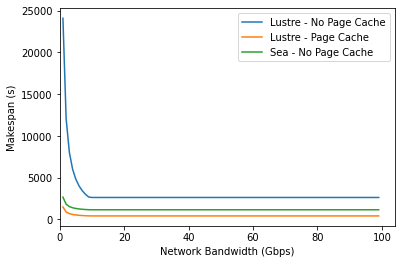

In [3]:
bw = range(128, 100*128, 128)
gbps = [b/128 for b in bw]

F = 617
n_f = 999 #1000
D_in = F * n_f
N_c = 4
N_d = 4
d = 6
I = 10
C = 0.40
A = 200 * 1024
n = 6
O = 44
B_n = 25 * 128
B_lr = 200
B_lw = 191
B_mr = 6676.48 #6760 * 7
B_mw = 2560 * 7
B_dr = 500
B_dw = 426
S_t = 126 * 1024
S_d = 447 * 1024

lustre_npc = [M_l(D_in, I, O, n, N_c, N_d, b, B_lr, B_lw) for b in bw]
lustre_pc = [M_lpc(D_in, N_c, N_d, I, C, A, F, n, O, b, B_lr, B_lw, B_mr, B_mw) for b in bw]
sea_npc = [M_s(D_in, I, S_t, F, n, N_c, S_d, d, b, B_lr, B_lw, N_d, O, B_mr, B_mw, B_dr, B_dw) for b in bw]

import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=gbps, y=lustre_npc, label="Lustre - No Page Cache")
sns.lineplot(x=gbps, y=lustre_pc, label="Lustre - Page Cache")
sns.lineplot(x=gbps, y=sea_npc, label="Sea - No Page Cache")
plt.xlabel("Network Bandwidth (Gbps)")
plt.ylabel("Makespan (s)")
plt.xlim(0)

In [4]:
F = 617
n_f = 1000
D_in = F * n_f
N_c = 5
N_d = 6
d = 6
I = 10
C = 0.40
A = 200 * 1024
n = 6
O = 44
B_n = 25 * 128
B_lr = 200
B_lw = 191
B_mr = 6676.48 #6760 * 7
B_mw = 2560 * 16
B_dr = 500
B_dw = 426
S_t = 126 * 1024
S_d = 447 * 1024

def reset_params():
    global F, n_f, D_in, N_c, N_d, d, I, C, A, n, O, B_n, B_lr, B_lw, B_mr, B_mw, B_dr, B_dw, S_t, S_d
    F = 617
    n_f = 1000
    D_in = F * n_f
    N_c = 5
    N_d = 6
    d = 6
    I = 5
    C = 0.40
    A = 200 * 1024
    n = 6
    O = 44
    B_n = 25 * 128
    B_lr = 200
    B_lw = 191
    B_mr = 6676.48 #6760 * 7
    B_mw = 2560 * 16
    B_dr = 500
    B_dw = 426
    S_t = 126 * 1024
    S_d = 447 * 1024

### Model evaluation - Number of nodes

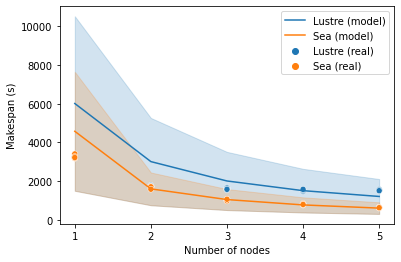

index  repetition   runtime  disk_files  total_flush
nodes                                                         
1      0.920000         1.0  0.998300         NaN     1.683332
2      1.076271         1.0  1.035257         NaN     5.310110
3      0.975207         1.0  1.556490         NaN    10.000000
4      0.881481         1.0  1.913208         NaN    10.000000
5      1.075630         1.0  2.431997         NaN    10.000000

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

bw = range(128, 100*128, 128)
gbps = [b/128 for b in bw]

reset_params()
I=10

newmodel_lustre = lambda sc, bmw, d, blw: sc/bmw + (d - sc)/blw
newmodel_sea = lambda st, bmw, sd, bdw, d, blw: st/bmw + sd/bdw + (d - st -sd)/blw
newmodel_speedup = lambda sc, st, sd, bmw, bdw, blw: sd/blw - sd/bdw + (st - sc)/blw - (st - sc)/bdw

nodes = list(range(1,6))
model_lustre = [newmodel_lustre(A*C, B_mw, D_in*I, lustre_wbw(B_n, nc, N_d, B_lw, O, n)) for nc in nodes]
model_sea = [newmodel_sea(S_t, B_mw, S_d, B_dw*d*nc, D_in*I, lustre_wbw(B_n, nc, N_d, B_lw, O, n)) for nc in nodes]
model_speedup = [newmodel_speedup(A*C,
                                  S_t,
                                  S_d,
                                  B_mw,
                                  B_dw*d*nc,
                                  lustre_wbw(B_n, nc, N_d, B_lw, O, n))
                 for nc in nodes]


lustre_npc = [M_l(D_in, I, O, n, nc, N_d, B_n, B_lr, B_lw) for nc in nodes]
lustre_pc = [M_lpc(D_in, nc, N_d, I, C, A, F, n, O, B_n, B_lr, B_lw, B_mr, B_mw) for nc in nodes]
sea_npc = [M_s(D_in, I, S_t, F, n, nc, S_d, d, B_n, B_lr, B_lw, N_d, O, B_mr, B_mw, B_dr, B_dw) for nc in nodes]

df_lustre = pd.read_csv("../results_new/exp_nodes.out")#_lustre.out")
df_lustre["nodes"] = df_lustre["experiment"].apply(lambda row: int(row.split('n_')[0].split("_")[-1]))
df_lustre["fs"] = df_lustre["experiment"].apply((lambda row: row.split("_")[0] if "lustre" in row else row.split("_")[1]))
df_lustre.loc[df_lustre["fs"] == "mem", "fs"] = "Sea (real)"
df_lustre.loc[df_lustre["fs"] == "lustre", "fs"] = "Lustre (real)"
df_lustre = df_lustre.sort_values(by=["fs", "nodes"])


sns.lineplot(x=nodes+nodes, y=lustre_pc + lustre_npc, label="Lustre (model)")
sns.lineplot(x=nodes+nodes, y=lustre_pc + sea_npc, label="Sea (model)")
#sns.lineplot(x=nodes, y=model_lustre, label="Lustre - Model")
#sns.lineplot(x=nodes, y=model_sea, label="Sea - Model")
sns.scatterplot(data=df_lustre, x="nodes", y="runtime", hue="fs")
plt.xlabel("Number of nodes")
plt.ylabel("Makespan (s)")
plt.legend(title=None)
plt.xticks(nodes)
#plt.savefig("/home/valeriehayot/Documents/code/phdthesis/figures/sea-comp/nodes.pdf")
plt.show()

df_s = df_lustre[df_lustre["fs"] == "Sea (real)"] \
    .sort_values("nodes") \
    .reset_index() \
    .groupby("nodes") \
    .mean()
df_l = df_lustre[df_lustre["fs"] == "Lustre (real)"] \
    .sort_values("nodes") \
    .reset_index() \
    .groupby("nodes") \
    .mean()
df_l / df_s#, df_l, df_s

### Model evaluation - Number of disks

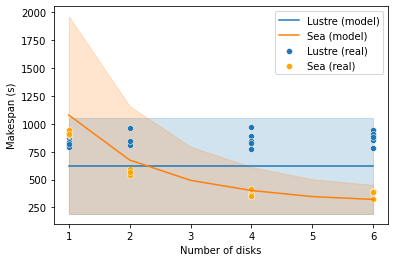

index  repetition   runtime  disk_files  total_flush
disks                                                          
1      45.588554   428.53241  0.935252         inf     0.533133
2      44.178599   428.53241  1.491713         inf     0.857065
4      46.579610   428.53241  2.298998         inf     0.857065
6      42.012981   428.53241  2.275406         inf     0.857065

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

nodes = 5
disks = list(range(1, 7))

reset_params()

lustre_npc = [M_l(D_in, I, O, n, nodes, N_d, B_n, B_lr, B_lw) for d in disks]
lustre = [M_lpc(D_in, nodes, N_d, I, C, A, F, n, O, B_n, B_lr, B_lw, B_mr, B_mw) for d in disks]
sea_npc = [M_s(D_in, I, S_t, F, n, nodes, S_d, di, B_n, B_lr, B_lw, N_d, O, B_mr, B_mw, B_dr, B_dw) for di in disks]

model_lustre = [newmodel_lustre(A*C, B_mw, D_in*I, lustre_wbw(B_n, nodes, N_d, B_lw, O, n)) for di in disks]
model_sea = [newmodel_sea(S_t, B_mw, S_d, B_dw*di*nodes, D_in*I, lustre_wbw(B_n, nodes, N_d, B_lw, O, n)) for di in disks]
model_speedup = [newmodel_speedup(A*C,
                                  S_t,
                                  S_d,
                                  B_mw,
                                  B_dw*di*nodes,
                                  lustre_wbw(B_n, nodes, N_d, B_lw, O, n))
                 
                 for di in disks]

# df_lustre = pd.read_csv("../results_new/exp_iterations.out")#_lustre.out")
# df_lustre["nodes"] = df_lustre["experiment"].apply(lambda row: int(row.split('n_')[0].split("_")[-1]))
# df_lustre["fs"] = df_lustre["experiment"].apply(lambda row: row.split("_")[0])
# df_lustre["iterations"] = df_lustre["experiment"].apply(lambda row: int(row.split("_")[-1].strip("i")))
# df_lustre = df_lustre[(df_lustre["fs"] == "lustre") & (df_lustre["iterations"] == 5)]
# df_lustre.loc[df_lustre["fs"] == "lustre", "fs"] = "Lustre (real)"
# df_lustre = df_lustre.sort_values(by=["fs", "nodes"])

df_lustre = pd.read_csv("../results_new/exp_dlustre.out")
df_lustre["disks"] = df_lustre["experiment"].apply(lambda name: int(name.split("d_")[0].split("_")[-1]))
df_lustre["fs"] = df_lustre["experiment"].apply(lambda name: name.split("_")[0])
df_lustre = df_lustre.sort_values(by=['fs','disks'])


df_l = pd.read_csv("../results_new/exp_disks.out")
df_l["disks"] = df_l["experiment"].apply(lambda name: int(name.split("d_")[0].split("_")[-1]))
df_l["fs"] = df_l["experiment"].apply(lambda name: name.split("_")[0])
df_l = df_l.sort_values(by=['fs','disks'])

df_l = df_l[~df_l["experiment"].str.contains("cp")]
sns.lineplot(x=disks + disks, y=lustre_npc + lustre, label="Lustre (model)")
sns.lineplot(x=disks+disks, y=sea_npc + lustre, label="Sea (model)")
#sns.lineplot(x=disks, y=model_lustre, label="Lustre (Model)")
#sns.lineplot(x=disks, y=model_sea, label="Sea (Model)")
# sns.lineplot(x=range(1, 7), y=[df_lustre["runtime"].mean()]*6, linestyle='--', color="blue", label="Lustre (real)")
sns.scatterplot(data=df_lustre, x="disks", y="runtime", label="Lustre (real)")
sns.scatterplot(data=df_l, x="disks", y="runtime", color="orange", label="Sea (real)")
plt.xlabel("Number of disks")
plt.ylabel("Makespan (s)")
plt.xticks(disks)
#plt.savefig("/home/valeriehayot/Documents/code/phdthesis/figures/sea-comp/disks.pdf")
plt.show()
#df_l
df_s = df_l\
    .sort_values("disks") \
    .reset_index() \
    .groupby("disks") \
    .mean()

df_lustre["runtime"].mean() / df_s

### Model evaluation - Number of iterations (NEEDS TO BE REDONE)

index  repetition   runtime  disk_files  total_flush
iterations                                                         
1           1.120567         1.0  0.933250         NaN          NaN
5           1.073826         1.0  1.992351         NaN          NaN
10          0.920530         1.0  2.600868         NaN          NaN
15          1.085106         1.0  2.308741         NaN          NaN

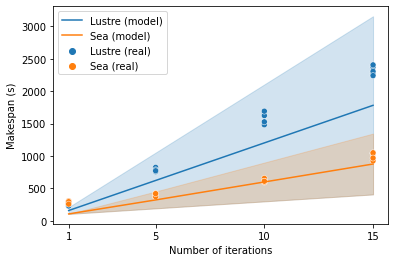

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# F = 617
# n_f = 1000
# D_in = F * n_f
# N_c = 5
# N_d = 6
# d = 6
# I = 5
# C = 0.40
# A = 256 * 1024
# O = 44
# B_n = 25 * 128
# B_lr = 200
# B_lw = 191
# B_mr = 6676.48 #6760 * 7
# B_mw = 2560 * 7
# B_dr = 500
# B_dw = 426
# S_t = 126 * 1024
# S_d = 447 * 1024
# d = 6
# n = 6
n_iterations = [1, 5, 10, 15]

reset_params()
lustre = [M_lpc(D_in, N_c, N_d, i, C, A, F, n, O, B_n, B_lr, B_lw, B_mr, B_mw) for i in n_iterations]
lustre_npc = [M_l(D_in, i, O, n, N_c, N_d, B_n, B_lr, B_lw) for i in n_iterations]
sea_npc = [M_s(D_in, i, S_t, F, n, N_c, S_d, d, B_n, B_lr, B_lw, N_d, O, B_mr, B_mw, B_dr, B_dw) for i in n_iterations]


model_lustre = [newmodel_lustre(A*C, B_mw, D_in*I, lustre_wbw(B_n, N_c, N_d, B_lw, O, n)) for I in n_iterations]
model_sea = [newmodel_sea(S_t, B_mw, S_d, B_dw*d*N_c, D_in*I, lustre_wbw(B_n, N_c, N_d, B_lw, O, n)) for I in n_iterations]
model_speedup = [newmodel_speedup(A*C,
                                  S_t,
                                  S_d,
                                  B_mw,
                                  B_dw*d*N_c,
                                  lustre_wbw(B_n, N_c, N_d, B_lw, O, n))
                 for I in n_iterations]
df_lustre = pd.read_csv("../results_new/exp_iterations.out")
df_lustre["iterations"] = df_lustre["experiment"].apply(lambda row: int(row.split("_")[-1].strip("i")))
df_lustre["fs"] = df_lustre["experiment"].apply((lambda row: row.split("_")[0]))
df_lustre = df_lustre[~df_lustre["fs"].str.contains("cp")]
df_lustre.loc[df_lustre["fs"] == "seamem", "fs"] = "Sea (real)"
df_lustre.loc[df_lustre["fs"] == "lustre", "fs"] = "Lustre (real)"
df_lustre = df_lustre.sort_values(by="fs").rename(columns={"fs": "File system"})
# df_mem = pd.read_csv("../results/exp_iterations_sea.out")
# df_mem["iterations"] = df_mem["experiment"].apply(lambda row: int(row.split("_")[-1].strip("i")))
# df_mem["experiment"] = df_mem["experiment"].apply((lambda row: row.split("_")[0] if "lustre" in row else row.split("_")[1]))

its = n_iterations
sns.lineplot(x=its+its, y=lustre+lustre_npc, label="Lustre (model)")
sns.lineplot(x=its+its, y=lustre+sea_npc, label="Sea (model)")
#sns.lineplot(x=its, y=model_lustre, label="Lustre - Model")
#sns.lineplot(x=its, y=model_sea, label="Sea - Model")
sns.scatterplot(data=df_lustre, x="iterations", y="runtime", hue="File system")
#sns.lineplot(x=n_iterations, y=lustre_npc, label="Lustre - Page Cache (Model)")
plt.xlabel("Number of iterations")
plt.ylabel("Makespan (s)")
plt.xticks(n_iterations)
plt.legend(loc="upper left", title=None)
plt.savefig("/home/valeriehayot/Documents/code/phdthesis/figures/sea-comp/iterations.pdf")
#plt.show()
#df = pd.merge(df_mem, df_lustre.sort_values(["iterations"])[["iterations", "runtime"]], on="iterations")
#df["speedup"] = df["runtime_y"] / df["runtime_x"]
df_s = df_lustre[df_lustre["File system"] == "Sea (real)"] \
    .sort_values("iterations") \
    .reset_index() \
    .groupby("iterations") \
    .mean()
df_l = df_lustre[df_lustre["File system"] == "Lustre (real)"] \
    .sort_values("iterations") \
    .reset_index() \
    .groupby("iterations") \
    .mean()
df_l / df_s#, df_l, df_s

### Model evaluation - Number of files (NEEDS TO BE REDONE)

experiment  repetition     runtime  \
1    lustre_5n_6t_6d_5000f_617m_5i           0  164.292649   
3    lustre_5n_6t_6d_1000f_617m_5i           0  848.102596   
6    lustre_5n_6t_6d_1000f_617m_5i           1  809.763753   
7    lustre_5n_6t_6d_5000f_617m_5i           1  175.260196   
10   lustre_5n_6t_6d_5000f_617m_5i           2  171.714757   
11   lustre_5n_6t_6d_1000f_617m_5i           2  921.034470   
12   lustre_5n_6t_6d_5000f_617m_5i           3  166.409587   
13   lustre_5n_6t_6d_1000f_617m_5i           3  850.909030   
16   lustre_5n_6t_6d_1000f_617m_5i           4  899.322866   
17   lustre_5n_6t_6d_5000f_617m_5i           4  164.213401   
0   sea_mem_5n_6t_6d_5000f_617m_5i           0   92.342818   
2   sea_mem_5n_6t_6d_1000f_617m_5i           0  322.232959   
4   sea_mem_5n_6t_6d_5000f_617m_5i           1   86.715636   
5   sea_mem_5n_6t_6d_1000f_617m_5i           1  381.494415   
8   sea_mem_5n_6t_6d_1000f_617m_5i           2  334.764403   
9   sea_mem_5n_6t_6d_5000f_617m_5i           2   87.892520   
14  sea_mem_5n_6t_6d_5000f_617m_5i           3   90.639546   
15  sea_mem_5n_6t_6d_1000f_617m_5i           3  389.821650   
18  sea_mem_5n_6t_6d_1000f_617m_5i           4  352.022664   
19  sea_mem_5n_6t_6d_5000f_617m_5i           4   89.279879   

                                           flush_time  disk_files  \
1                                                 NaN           0   
3                                                 NaN           0   
6                                                 NaN           0   
7                                                 NaN           0   
10                                                NaN           0   
11                                                NaN           0   
12                                                NaN           0   
13                                                NaN           0   
16                                                NaN           0   
17                                                NaN           0   
0   0m9.694s real 0m6.973s real 0m4.814s real 0m4....           0   
2   0m7.439s real 0m12.291s real 0m9.122s real 0m5...           0   
4   0m7.491s real 0m6.004s real 0m5.745s real 0m6....           0   
5   0m9.344s real 0m4.265s real 0m11.262s real 0m9...           0   
8   0m12.476s real 0m9.821s real 0m24.476s real 0m...           0   
9   0m9.581s real 0m10.084s real 0m5.661s real 0m5...           0   
14  0m7.130s real 0m8.075s real 0m7.738s real 0m6....           0   
15  0m7.974s real 0m10.568s real 0m5.438s real 0m2...           0   
18  0m12.111s real 0m4.038s real 0m3.350s real 0m5...           0   
19  0m9.890s real 0m8.961s real 0m8.040s real 0m6....           0   

    total_flush             fs  
1          5000  Lustre (real)  
3          5000  Lustre (real)  
6          5000  Lustre (real)  
7          5000  Lustre (real)  
10         5000  Lustre (real)  
11         5000  Lustre (real)  
12         5000  Lustre (real)  
13         5000  Lustre (real)  
16         5000  Lustre (real)  
17         5000  Lustre (real)  
0          1000            mem  
2          1000            mem  
4          1000            mem  
5          1000            mem  
8          1000            mem  
9          1000            mem  
14         1000            mem  
15         1000            mem  
18         1000            mem  
19         1000            mem

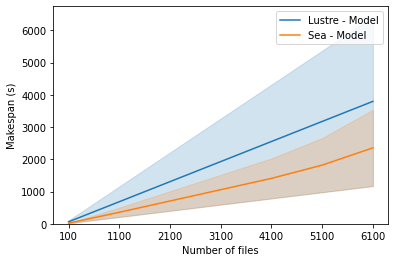

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

num_files = list(range(100, 7001, 1000))

lustre = [M_lpc(f*F, N_c, N_d, I, C, A, F, n, O, B_n, B_lr, B_lw, B_mr, B_mw) for f in num_files]
lustre_npc = [M_l(f*F, I, O, n, N_c, N_d, B_n, B_lr, B_lw) for f in num_files]
sea_npc = [M_s(f*F, I, S_t, F, n, N_c, S_d, d, B_n, B_lr, B_lw, N_d, O, B_mr, B_mw, B_dr, B_dw) for f in num_files]

df_lustre = pd.read_csv("../results_new/exp_files.out")
df_lustre["fs"] = df_lustre["experiment"].apply((lambda row: row.split("_")[0] if "lustre" in row else row.split("_")[1]))
df_lustre = df_lustre.sort_values(by=["fs", "total_flush"])
df_lustre.loc[df_lustre["fs"] == "sea_mem", "fs"] = "Sea (real)"
df_lustre.loc[df_lustre["fs"] == "lustre", "fs"] = "Lustre (real)"

sns.lineplot(x=num_files+num_files, y=lustre+lustre_npc, label="Lustre - Model")
sns.lineplot(x=num_files+num_files, y=lustre+sea_npc, label="Sea - Model")
#sns.lineplot(x=num_files, y=lustre_npc, label="Lustre - No Page Cache (Model)")
plt.xlabel("Number of files")
plt.ylabel("Makespan (s)")
plt.xticks(num_files)
plt.ylim(0)

df_lustre

### Model evaluation - Number of threads

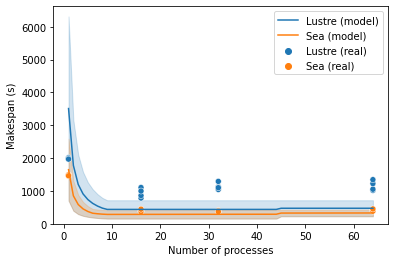

index  repetition      runtime  disk_files  total_flush
threads                                                         
1        34.50         2.5  1990.745063         0.0       5000.0
16       31.75         2.5   937.373873         0.0       5000.0
32       38.00         2.5  1140.881897         0.0       5000.0
64       34.25         2.5  1160.959668         0.0       5000.0

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

threads = list(range(1, 65))

# F = 617
# n_f = 1000
# D_in = F * n_f
# N_c = 5
# N_d = 6
# d = 6
# I = 5
# C = 0.40
# A = 256 * 1024
# O = 44
# B_n = 25 * 128
# B_lr = 200
# B_lw = 191
# B_mr = 6676.48 #6760 * 7
# B_mw = 2560 * 7
# B_dr = 500
# B_dw = 426
# S_t = 126 * 1024
# S_d = 447 * 1024

reset_params()

newmodel_lustre = lambda sc, bmw, d, blw: sc/bmw + (d - sc)/blw
newmodel_sea = lambda st, bmw, sd, bdw, d, blw: st/bmw + sd/bdw + (d - st -sd)/blw
newmodel_speedup = lambda sc, st, sd, bmw, bdw, blw: sd/blw - sd/bdw + (st - sc)/blw - (st - sc)/bdw

model_lustre = [newmodel_lustre(A*C, B_mw, D_in*I, lustre_wbw(B_n, N_c, N_d, B_lw, O, n)) for n in threads]
model_sea = [newmodel_sea(S_t, B_mw, S_d, B_dw*d*N_c, D_in*I, lustre_wbw(B_n, N_c, N_d, B_lw, O, n)) for n in threads]
model_speedup = [newmodel_speedup(A*C,
                                  S_t,
                                  S_d,
                                  B_mw,
                                  B_dw*d*N_c,
                                  lustre_wbw(B_n, N_c, N_d, B_lw, O, n))
                 for n in threads]


lustre = [M_lpc(D_in, N_c, N_d, I, C, A, F, t, O, B_n, B_lr, B_lw, B_mr, B_mw) for t in threads]
lustre_npc = [M_l(D_in, I, O, t, N_c, N_d, B_n, B_lr, B_lw) for t in threads]
sea_npc = [M_s(D_in, I, S_t, F, t, N_c, S_d, d, B_n, B_lr, B_lw, N_d, O, B_mr, B_mw, B_dr, B_dw) for t in threads]

df_lustre = pd.read_csv("../results_new/exp_threads.out")
df_lustre["fs"] = df_lustre["experiment"].apply(lambda x: "_".join(x.split("_")[0:2]) if "sea" in x else x.split("_")[0])
df_lustre = df_lustre[df_lustre["fs"] != "sea_cp"]
df_lustre["threads"] = df_lustre["experiment"].apply(lambda row: int(row.split("t_")[0].split("_")[-1]))
df_lustre = df_lustre.sort_values(by=["fs", "threads"])
df_lustre = df_lustre[df_lustre["repetition"] > 0]
df_lustre = df_lustre[df_lustre["runtime"] < 3000]

sns.lineplot(x=threads+threads, y=lustre + lustre_npc, label="Lustre (model)")
sns.lineplot(x=threads+threads, y=lustre + sea_npc, label="Sea (model)")
#sns.lineplot(x=threads, y=model_lustre, label="Lustre (Model)")
#sns.lineplot(x=threads, y=model_sea, label="Sea (Model)")
df_lustre.loc[df_lustre["fs"] == "sea_mem", "fs"] = "Sea (real)"
df_lustre.loc[df_lustre["fs"] == "lustre", "fs"] = "Lustre (real)"
df_lustre = df_lustre.rename(columns={"fs": "File system"})
sns.scatterplot(data=df_lustre, x="threads", y="runtime", hue="File system")

plt.xlabel("Number of processes")
plt.ylabel("Makespan (s)")
plt.ylim(0)
plt.legend(title=None)
plt.savefig("/home/valeriehayot/Documents/code/phdthesis/figures/sea-comp/threads.pdf")
plt.show()
model_lustre, model_sea, model_speedup
#df = pd.merge(df_mem, df_lustre.sort_values(["threads"])[["threads", "runtime"]], on="threads")
#df["speedup"] = df["runtime_y"] / df["runtime_x"]
df_s = df_lustre[df_lustre["File system"] == "Sea (real)"] \
    .sort_values("threads") \
    .reset_index() \
    .groupby("threads") \
    .mean()
df_l = df_lustre[df_lustre["File system"] == "Lustre (real)"] \
    .sort_values("threads") \
    .reset_index() \
    .groupby("threads") \
    .mean()
df_l# / df_s

repetition      Runtime  disk_files  total_flush  iterations
Experiment                                                                 
Lustre                  2  1164.939644           0         5000           5
Sea:flush-all           2  1487.539792           0         5000           5
Sea:in-memory           2   423.823263           0         1000           5

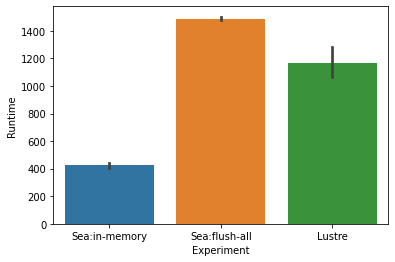

In [10]:
df_lustre = pd.read_csv("../results_new/exp_threads.out")
df_lustre["iterations"] = df_lustre["experiment"].apply(lambda row: int(row.split("_")[-1].strip("i")))
df_lustre["fs"] = df_lustre["experiment"].apply((lambda row: row.split("_")[0]))
df_lustre["threads"] = df_lustre["experiment"].apply((lambda row: row.split("_")[3 if "sea" in row else 2]))
df_lustre["experiment"] = df_lustre["experiment"].apply((lambda row: "Sea:flush-all" if "cp" in row else "Sea:in-memory" if "mem" in row  else "Lustre"))

#df_lustre.loc[~df_lustre['flush_time'].isna()]
#df_lustre["flush"] = df_lustre.loc[~df_lustre['flush_time'].isna()]["flush_time"].apply(lambda x:max([int(t.split("m")[0])*60 + float(t.split("m")[1].strip('s')) for t in x.split(" real ")]))

#df_lustre["experiment"] = df_lustre["experiment"].apply((lambda row: row.split("_")[0]))
#df_lustre = df_lustre[~df_lustre["experiment"].str.contains("cp")]
df_lustre = df_lustre.rename(columns={"experiment":"Experiment", "runtime": "Runtime"})
order = ["Sea:in-memory", "Sea:flush-all", "Lustre"]

sns.barplot(x="Experiment", y="Runtime", data=df_lustre[df_lustre["threads"] == "64t"].set_index("Experiment").loc[order].reset_index())
plt.savefig("/home/valeriehayot/Documents/code/phdthesis/figures/sea-comp/flushall.pdf")
df_lustre[df_lustre["threads"] == "64t"].groupby("Experiment").mean()

## Read only experiments - 1 iteration

In [11]:
1487.539792/423.823263, 1487.539792/1164.939644

(3.5098115697344343, 1.2769243451036678)

$$ M_{l} =  \frac{D_{in}I}{\min{(B_{n}N_{c}, B_{n}N_{d}, B_{lr}\min{(O, nN_{c}}))}} + \frac{D_{in}I}{\min{(B_{n}N_{c}, B_{n}N_{d}, B_{lw}\min{(O, nN_{c}}))}}$$

$\text{Where,}$<br>
$M_{l}$ represents Lustres makespan<br>
$D_{in}$ is the size of the input dataset<br>
$I$ is the total number of iterations<br>
$O$ is the number of Lustre OSTs<br>
$N_{c}$ is the number of compute nodes<br>
$N_{d}$ is the number of data nodes<br>
$B_{n}$ is the network bandwidth<br>
$B_{lr}$ is a Lustre OST's read bandwidth<br>
$B_{lw}$ is a Lustre OST's write bandwidth<br>

## Gantts for Sea node experiments

In [12]:
import figures as fg
data = "../results/exp_threads/run-0/lustre_5n_64t_6d_1000f_617m_5i/benchmarks.out"
df = fg.load_df(data)
print(df.groupby("action")["duration"].mean())
fg.bokeh_gantt(df)

action
increment     0.7986
read         21.5076
write        25.8464
Name: duration, dtype: float64


Loading BokehJS ...

In [13]:
import figures as fg
data = "../results/exp_threads/run-0/sea_mem_5n_64t_6d_1000f_617m_5i/benchmarks.out"
df = fg.load_df(data)
print(df.groupby("action")["duration"].mean())
fg.bokeh_gantt(df)

action
increment     0.8294
read          2.8172
write        15.8744
Name: duration, dtype: float64


Loading BokehJS ...

In [14]:
import figures as fg
data = "../results/exp_threads/run-0/sea_cp_5n_64t_6d_1000f_617m_5i/benchmarks.out"
df = fg.load_df(data)
print(df.groupby("action")["duration"].mean())
fg.bokeh_gantt(df)

action
increment     0.8462
read          2.8274
write        13.3168
Name: duration, dtype: float64


Loading BokehJS ...

In [15]:
import figures as fg
data = "../results/exp_nodes/run-0/lustre_5n_6t_6d_1000f_617m_10i/benchmarks.out"
df = fg.load_df(data)
print(df.groupby("action")["duration"].mean())
fg.bokeh_gantt(df)

action
increment    0.000
read         9.201
write        0.994
Name: duration, dtype: float64


Loading BokehJS ...